## **Variational classifier**


## **Imports**


In [3]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer

Quantum and classical nodes
===========================
```java
We then create a quantum device that will run our circuits.
```

In [90]:
dev = qml.device("default.qubit")

```python
In this circuit, every qbit has a rotation that has 3 parameters, then weh just have CNOT operators between the difrrent qbits, except between 1 and 3, this structure can be repeated any number of times, and the more layers we have the more degrees of freedom we have
```

In [91]:
def layer(layer_weights):
    for wire in range(4):
        qml.Rot(*layer_weights[wire], wires=wire)

    for wires in ([0, 1], [1, 2], [2, 3], [3, 0]):
        qml.CNOT(wires)

```java
One of the main challenges we will face is the need to encode data. Different strategies are available depending on our data. In this first example, we use the basis state encoding method, which converts binary values into states in the quantum circuit. For instance, in this case, the code uses 4 qubits to represent any data point in the dataset. One disadvantage of this method is the limited number of values it can represent; with 4 qubits, we can represent in this case 2 ^ 4 = 16 values. Therefore, with  n qbits we can represent 2 ^ n values.
```

In [92]:
def state_preparation(x):
    qml.BasisState(x, wires=[0, 1, 2, 3])

```java
After we have define the encoding and the repetitive structure or structures that we will use, we can create our circuit, in gthis case is pretty simple, just first the encoding layer state_preparation() and our trainable layer(), after denining that we can take the expected value of the PauliZ opertator.
```


In [93]:
@qml.qnode(dev)
def circuit(weights, x):
    state_preparation(x)

    for layer_weights in weights:
        layer(layer_weights)

    return qml.expval(qml.PauliZ(0))

```java
Here we define our model. As we can see, it is determined by the weights and the bias. However, we can make it more flexible.
```


In [134]:
def variational_classifier(weights, bias, x):
    return circuit(weights, x) + bias

```java
Also we have to define 3 important parts of a model, the cost function, our metric, and a loss function.

Here as a loss functon we use the square loss or also known as Mean square error
```

In [124]:
def square_loss(labels, predictions):
    # We use a call to qml.math.stack to allow subtracting the arrays directly
    return np.mean((labels - qml.math.stack(predictions)) ** 2)

```python
Next, we define a metric that provides a human-readable and interpretable value for evaluating the performance of the model. There are many metrics available, but for simplicity, we will use accuracy in this example.
```


In [125]:
def accuracy(labels, predictions):
    acc = sum(abs(l - p) < 1e-5 for l, p in zip(labels, predictions))
    acc = acc / len(labels)
    return acc

```python
In the end we defined our cost function, which is used to train the model, with this function the gradients are calculted and help te model to move in the right direction
```

In [126]:
def cost(weights, bias, X, Y):
    predictions = [variational_classifier(weights, bias, x) for x in X]
    return square_loss(Y, predictions)

## **Optimization of the model**

```java
Here we gather the data, so we can optimize the model, using the np.loadtxt() we can get the data from any place, a url or a folder
```

In [127]:
data = np.loadtxt("https://raw.githubusercontent.com/XanaduAI/qml/master/_static/demonstration_assets/variational_classifier/data/parity_train.txt", dtype=int)
X = np.array(data[:, :-1])
Y = np.array(data[:, -1])
Y = Y * 2 - 1  # shift label from {0, 1} to {-1, 1}

for x,y in zip(X, Y):
    print(f"x = {x}, y = {y}")

x = [0 0 0 1], y = 1
x = [0 0 1 0], y = 1
x = [0 1 0 0], y = 1
x = [0 1 0 1], y = -1
x = [0 1 1 0], y = -1
x = [0 1 1 1], y = 1
x = [1 0 0 0], y = 1
x = [1 0 0 1], y = -1
x = [1 0 1 1], y = 1
x = [1 1 1 1], y = -1


```javascript
In this section of the code some variables have been defined with the purpose of reproducibility in this case the weights and also the bias value
```


In [128]:
np.random.seed(0)
num_qubits = 4
num_layers = 2
weights_init = 0.01 * np.random.randn(num_layers + 1, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

print("Weights:", weights_init)
print("Bias: ", bias_init)

Weights: [[[ 0.01764052  0.00400157  0.00978738]
  [ 0.02240893  0.01867558 -0.00977278]
  [ 0.00950088 -0.00151357 -0.00103219]
  [ 0.00410599  0.00144044  0.01454274]]

 [[ 0.00761038  0.00121675  0.00443863]
  [ 0.00333674  0.01494079 -0.00205158]
  [ 0.00313068 -0.00854096 -0.0255299 ]
  [ 0.00653619  0.00864436 -0.00742165]]

 [[ 0.02269755 -0.01454366  0.00045759]
  [-0.00187184  0.01532779  0.01469359]
  [ 0.00154947  0.00378163 -0.00887786]
  [-0.01980796 -0.00347912  0.00156349]]]
Bias:  0.0


```javascript
Any model optimized using gradient descent techniques requires an optimizer. There are many optimizers available, such as Adam, Adagrad, pure gradient descent, and Momentum. In PennyLane, many of these optimizers are implemented.
```

In [132]:
opt = NesterovMomentumOptimizer(0.5)
batch_size = 5

```javascript
The next section is the optimization (training) loop. The main thing to notice is that the predictions are passed through the np.sign() function. This is done to convert the model's output into actual predictions: any negative value is converted to -1, and any positive value is converted to +1.
```


In [154]:
weights = weights_init
bias = bias_init
for it in range(100):

    # Update the weights by one optimizer step, using only a limited batch of data
    batch_index = np.random.randint(0, len(X), (batch_size,))
    X_batch = X[batch_index]
    Y_batch = Y[batch_index]
    weights, bias = opt.step(cost, weights, bias, X=X_batch, Y=Y_batch)

    # Compute accuracy
    predictions = [np.sign(variational_classifier(weights, bias, x)) for x in X]

    current_cost = cost(weights, bias, X, Y)
    acc = accuracy(Y, predictions)

    print(f"Iter: {it+1:4d} | Cost: {current_cost:0.7f} | Accuracy: {acc:0.7f}")

Iter:    1 | Cost: 2.1547023 | Accuracy: 0.7000000
Iter:    2 | Cost: 1.1460201 | Accuracy: 0.7000000
Iter:    3 | Cost: 1.1519004 | Accuracy: 0.7000000
Iter:    4 | Cost: 0.9526674 | Accuracy: 0.7000000
Iter:    5 | Cost: 1.0458406 | Accuracy: 0.7000000
Iter:    6 | Cost: 0.5855633 | Accuracy: 0.8000000
Iter:    7 | Cost: 0.3056156 | Accuracy: 1.0000000
Iter:    8 | Cost: 0.0168400 | Accuracy: 1.0000000
Iter:    9 | Cost: 0.0168087 | Accuracy: 1.0000000
Iter:   10 | Cost: 0.0465406 | Accuracy: 1.0000000
Iter:   11 | Cost: 0.0559354 | Accuracy: 1.0000000
Iter:   12 | Cost: 0.0322099 | Accuracy: 1.0000000
Iter:   13 | Cost: 0.0230070 | Accuracy: 1.0000000
Iter:   14 | Cost: 0.0272010 | Accuracy: 1.0000000
Iter:   15 | Cost: 0.0519792 | Accuracy: 1.0000000
Iter:   16 | Cost: 0.2157166 | Accuracy: 1.0000000
Iter:   17 | Cost: 0.0865568 | Accuracy: 1.0000000
Iter:   18 | Cost: 0.5063827 | Accuracy: 1.0000000
Iter:   19 | Cost: 0.2028515 | Accuracy: 1.0000000
Iter:   20 | Cost: 0.8933117 | 

In [20]:
weights , bias

(tensor([[[ 1.76405235e-02,  1.56275530e+00,  9.41007496e+00],
          [ 2.24089320e-02,  1.73042677e+01, -3.18095132e+00],
          [ 9.50088418e-03,  3.15957666e+00, -1.32954606e-01],
          [ 4.10598502e-03,  4.72194868e+00,  4.52141863e-02]],
 
         [[ 7.61037725e-03,  1.21675016e-03,  4.43863233e-03],
          [-9.13257927e-01,  2.55275727e-02, -2.05158264e-03],
          [-1.08400003e+01, -1.57068301e+01, -2.55298982e-02],
          [-1.80411655e-02, -2.35109405e+01, -7.42165020e-03]]], requires_grad=True),
 tensor(0.00083823, requires_grad=True))

```javascript
Just as in machine learning, we want to assess the generalization ability of our model. This is done by evaluating the model on examples it has never seen before. For this purpose, we use the test data.
```


In [21]:
data = np.loadtxt("https://raw.githubusercontent.com/XanaduAI/qml/master/_static/demonstration_assets/variational_classifier/data/parity_test.txt", dtype=int)
X_test = np.array(data[:, :-1])
Y_test = np.array(data[:, -1])
Y_test = Y_test * 2 - 1  # shift label from {0, 1} to {-1, 1}
    
predictions_test = [np.sign(variational_classifier(weights, bias, x)) for x in X_test]

for x,y,p in zip(X_test, Y_test, predictions_test):
    print(f"x = {x}, y = {y}, pred={p}")
    
acc_test = accuracy(Y_test, predictions_test)
print("Accuracy on unseen data:", acc_test)

x = [0 0 0 0], y = -1, pred=-1.0
x = [0 0 1 1], y = -1, pred=-1.0
x = [1 0 1 0], y = -1, pred=-1.0
x = [1 1 1 0], y = 1, pred=1.0
x = [1 1 0 0], y = -1, pred=-1.0
x = [1 1 0 1], y = 1, pred=1.0
Accuracy on unseen data: 1.0


# Iris classification

```java
This tutorial also demonstrated how to train a model for even more complex data, in this case the encoding of the data was done base on the next code, which converts any vector X into another vector W compose of pure angles
```

In [24]:
def get_angles(x):
    beta0 = 2 * np.arcsin(np.sqrt(x[1] ** 2) / np.sqrt(x[0] ** 2 + x[1] ** 2 + 1e-12))
    beta1 = 2 * np.arcsin(np.sqrt(x[3] ** 2) / np.sqrt(x[2] ** 2 + x[3] ** 2 + 1e-12))
    beta2 = 2 * np.arcsin(np.linalg.norm(x[2:]) / np.linalg.norm(x))

    return np.array([beta2, -beta1 / 2, beta1 / 2, -beta0 / 2, beta0 / 2])


def state_preparation(a):
    qml.RY(a[0], wires=0)

    qml.CNOT(wires=[0, 1])
    qml.RY(a[1], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[2], wires=1)

    qml.PauliX(wires=0)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[3], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[4], wires=1)
    qml.PauliX(wires=0)

```java
This code was just for testing, as we can see any 4 dimensional vector is converted first in angles and then into an amplitud vector
```


In [25]:
x = np.array([0.53896774, 0.79503606, 0.27826503, 0.0], requires_grad=False)
ang = get_angles(x)


@qml.qnode(dev)
def test(angles):
    state_preparation(angles)

    return qml.state()


state = test(ang)

print("x               : ", np.round(x, 6))
print("angles          : ", np.round(ang, 6))
print("amplitude vector: ", np.round(np.real(state), 6))

x               :  [0.538968 0.795036 0.278265 0.      ]
angles          :  [ 0.563975 -0.        0.       -0.975046  0.975046]
amplitude vector:  [ 0.538968  0.795036  0.278265 -0.      ]


```javascript
Same as before we need to define our layers, our circuit and our cost function, in this case the metric was not defined because we use the same as before
```

In [26]:
def layer(layer_weights):
    for wire in range(2):
        qml.Rot(*layer_weights[wire], wires=wire)
    qml.CNOT(wires=[0, 1])


def cost(weights, bias, X, Y):
    # Transpose the batch of input data in order to make the indexing
    # in state_preparation work
    predictions = variational_classifier(weights, bias, X.T)
    return square_loss(Y, predictions)

```java
In this section, we gather the data and apply various transformations. For example, we first convert 2-dimensional vectors into 4-dimensional vectors. Next, we normalize these vectors. Finally, we apply angle encoding, which transforms the data into 5-dimensional vectors.
```

In [27]:
data = np.loadtxt("https://raw.githubusercontent.com/XanaduAI/qml/master/_static/demonstration_assets/variational_classifier/data/iris_classes1and2_scaled.txt")
X = data[:, 0:2]
print(f"First X sample (original)  : {X[0]}")

# pad the vectors to size 2^2=4 with constant values
padding = np.ones((len(X), 2)) * 0.1
X_pad = np.c_[X, padding]
print(f"First X sample (padded)    : {X_pad[0]}")

# normalize each input
normalization = np.sqrt(np.sum(X_pad**2, -1))
X_norm = (X_pad.T / normalization).T
print(f"First X sample (normalized): {X_norm[0]}")

# the angles for state preparation are the features
features = np.array([get_angles(x) for x in X_norm], requires_grad=False)
print(f"First features sample      : {features[0]}")

Y = data[:, -1]

First X sample (original)  : [0.4  0.75]
First X sample (padded)    : [0.4  0.75 0.1  0.1 ]
First X sample (normalized): [0.46420708 0.87038828 0.11605177 0.11605177]
First features sample      : [ 0.32973573 -0.78539816  0.78539816 -1.080839    1.080839  ]


```java
This part of the script handles plotting the data. As observed, the original data is already linearly separable, meaning any linear model could solve this classification task. Additionally, the second and third plots show data that is also linearly separable.
```

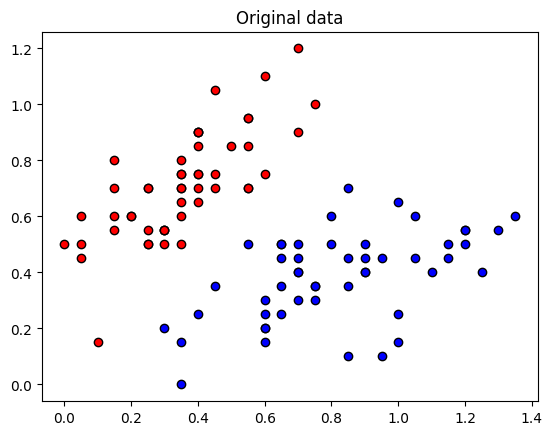

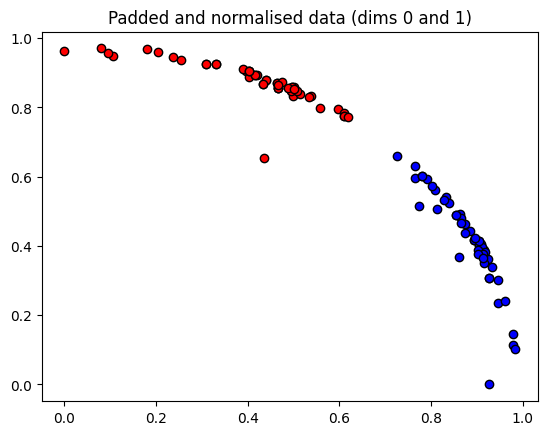

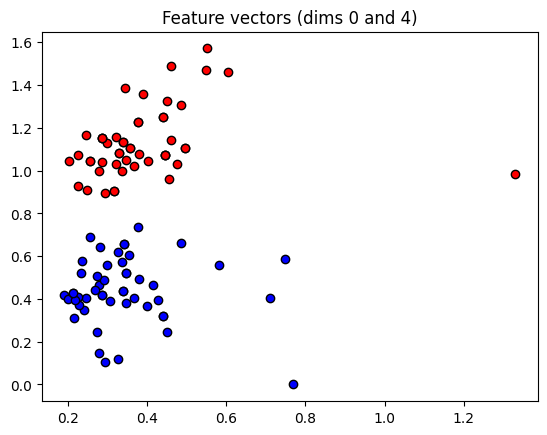

In [34]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(X[:, 0][Y == 1], X[:, 1][Y == 1], c="b", marker="o", ec="k")
plt.scatter(X[:, 0][Y == -1], X[:, 1][Y == -1], c="r", marker="o", ec="k")
plt.title("Original data")
plt.show()

plt.figure()
dim1 = 0
dim2 = 1
plt.scatter(X_norm[:, dim1][Y == 1], X_norm[:, dim2][Y == 1], c="b", marker="o", ec="k")
plt.scatter(X_norm[:, dim1][Y == -1], X_norm[:, dim2][Y == -1], c="r", marker="o", ec="k")
plt.title(f"Padded and normalised data (dims {dim1} and {dim2})")
plt.show()

plt.figure()
dim1 = 0
dim2 = 3
plt.scatter(features[:, dim1][Y == 1], features[:, dim2][Y == 1], c="b", marker="o", ec="k")
plt.scatter(features[:, dim1][Y == -1], features[:, dim2][Y == -1], c="r", marker="o", ec="k")
plt.title(f"Feature vectors (dims {dim1} and {dim2})")
plt.show()

```java
Finally same as the problem before, we can optimize the model to be able to make predictions, here we create some variables and take part of the data for training the circuit.
```

In [38]:
np.random.seed(0)
num_data = len(Y)
num_train = int(0.75 * num_data)
index = np.random.permutation(range(num_data))
feats_train = features[index[:num_train]]
Y_train = Y[index[:num_train]]
feats_val = features[index[num_train:]]
Y_val = Y[index[num_train:]]

# We need these later for plotting
X_train = X[index[:num_train]]
X_val = X[index[num_train:]]

In [51]:
num_qubits = 2
num_layers = 6

weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

### **Optimization of the second problem**


In [53]:
opt = NesterovMomentumOptimizer(0.01)
batch_size = 5

# train the variational classifier
weights = weights_init
bias = bias_init
for it in range(100):
    # Update the weights by one optimizer step
    batch_index = np.random.randint(0, num_train, (batch_size,))
    feats_train_batch = feats_train[batch_index]
    Y_train_batch = Y_train[batch_index]
    weights, bias, _, _ = opt.step(cost, weights, bias, feats_train_batch, Y_train_batch)

    # Compute predictions on train and validation set
    predictions_train = np.sign(variational_classifier(weights, bias, feats_train.T))
    predictions_val = np.sign(variational_classifier(weights, bias, feats_val.T))

    # Compute accuracy on train and validation set
    acc_train = accuracy(Y_train, predictions_train)
    acc_val = accuracy(Y_val, predictions_val)

    if (it + 1) % 2 == 0:
        _cost = cost(weights, bias, features, Y)
        print(
            f"Iter: {it + 1:5d} | Cost: {_cost:0.7f} | "
            f"Acc train: {acc_train:0.7f} | Acc validation: {acc_val:0.7f}"
        )

Iter:     2 | Cost: 1.6208140 | Acc train: 0.4800000 | Acc validation: 0.5600000
Iter:     4 | Cost: 1.2556744 | Acc train: 0.4933333 | Acc validation: 0.5600000
Iter:     6 | Cost: 1.0046104 | Acc train: 0.4533333 | Acc validation: 0.5600000
Iter:     8 | Cost: 0.9779141 | Acc train: 0.6000000 | Acc validation: 0.5200000
Iter:    10 | Cost: 1.1040985 | Acc train: 0.5200000 | Acc validation: 0.4400000
Iter:    12 | Cost: 1.0389020 | Acc train: 0.5200000 | Acc validation: 0.4400000
Iter:    14 | Cost: 0.8461431 | Acc train: 0.7200000 | Acc validation: 0.6800000
Iter:    16 | Cost: 0.9086640 | Acc train: 0.4933333 | Acc validation: 0.5600000
Iter:    18 | Cost: 0.9447327 | Acc train: 0.4933333 | Acc validation: 0.5600000
Iter:    20 | Cost: 0.9065158 | Acc train: 0.4933333 | Acc validation: 0.5600000
Iter:    22 | Cost: 0.7977272 | Acc train: 0.5600000 | Acc validation: 0.6400000
Iter:    24 | Cost: 0.6314015 | Acc train: 0.9200000 | Acc validation: 1.0000000
Iter:    26 | Cost: 0.515303

```java
After training using the next cell, we can observe how the variational classifier makes its predictions. The center of the plot represents the boundary between the classes.
```

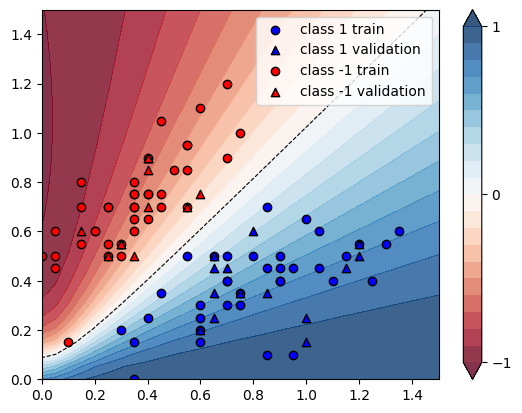

In [56]:
plt.figure()
cm = plt.cm.RdBu

# make data for decision regions
xx, yy = np.meshgrid(np.linspace(0.0, 1.5, 30), np.linspace(0.0, 1.5, 30))
X_grid = [np.array([x, y]) for x, y in zip(xx.flatten(), yy.flatten())]

# preprocess grid points like data inputs above
padding = 0.1 * np.ones((len(X_grid), 2))
X_grid = np.c_[X_grid, padding]  # pad each input
normalization = np.sqrt(np.sum(X_grid**2, -1))
X_grid = (X_grid.T / normalization).T  # normalize each input
features_grid = np.array([get_angles(x) for x in X_grid])  # angles are new features
predictions_grid = variational_classifier(weights, bias, features_grid.T)
Z = np.reshape(predictions_grid, xx.shape)

# plot decision regions
levels = np.arange(-1, 1.1, 0.1)
cnt = plt.contourf(xx, yy, Z, levels=levels, cmap=cm, alpha=0.8, extend="both")
plt.contour(xx, yy, Z, levels=[0.0], colors=("black",), linestyles=("--",), linewidths=(0.8,))
plt.colorbar(cnt, ticks=[-1, 0, 1])

# plot data
for color, label in zip(["b", "r"], [1, -1]):
    plot_x = X_train[:, 0][Y_train == label]
    plot_y = X_train[:, 1][Y_train == label]
    plt.scatter(plot_x, plot_y, c=color, marker="o", ec="k", label=f"class {label} train")
    plot_x = (X_val[:, 0][Y_val == label],)
    plot_y = (X_val[:, 1][Y_val == label],)
    plt.scatter(plot_x, plot_y, c=color, marker="^", ec="k", label=f"class {label} validation")

plt.legend()
plt.show()